# Working with geometries in pygris

Objects returned by __pygris__ functions are GeoPandas GeoDataFrames, allowing users access to all the methods associated with that object type.  __pygris__ also includes some special utilities to solve common use-cases when working with Census shapefiles.  

## Shifting and rescaling US geometries

A common problem when trying to create national maps of the United States is how to represent non-contiguous parts of the country such as Alaska, Hawaii, and Puerto Rico.  For example, a plot of US states by default appears as follows:

Using the default year of 2024


<Axes: >

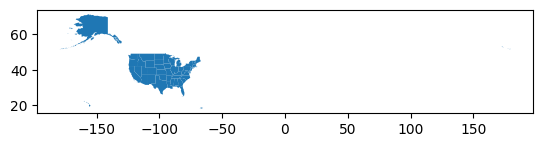

In [15]:
from pygris import states

us = states(cb = True, resolution = "20m")

us.plot()

The plot is disjointed as the Aleutian Islands in Alaska cross the 180 degree line of longitude and are plotted (near-invisibly) on the right-hand side of the map.  

__pygris__ includes a function, `shift_geometry()`, that offers an opinionated set of solutions to this problem.  The function shifts and optionally rescales geometries in Alaska, Hawaii, and Puerto Rico to locations that are more appropriate for national cartographic display.  

<Axes: >

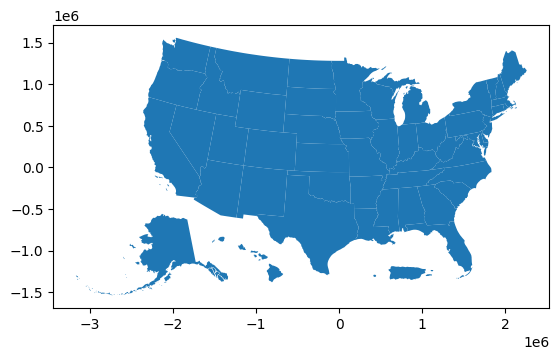

In [16]:
from pygris.utils import shift_geometry

us_rescaled = shift_geometry(us)

us_rescaled.plot()

Alaska, Hawaii, and Puerto Rico are re-scaled (with Alaska shrunk and Hawaii / Puerto Rico enlarged) and moved below the continental United States.  The function does not handle other US territories, so take care to filter those territories out first if using this function.  

Options in `shift_geometry()` include `preserve_area` (a boolean, defaults to `False`) and `position` (defaults to `"below"`, you can also choose `"outside"`).  For example, you may want to preserve the relative areas and relative positions of the non-contiguous US relative to the rest of the country.  This can be accomplished with the code below:

<Axes: >

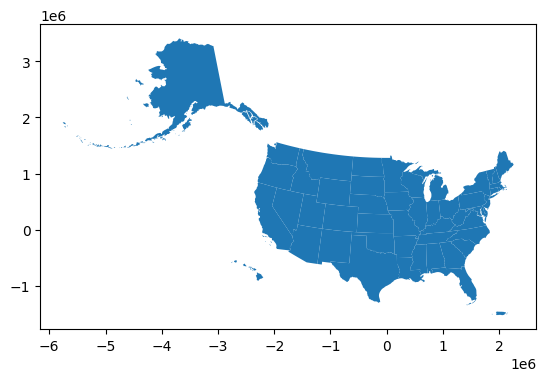

In [17]:
us_shifted = shift_geometry(us, position = "outside", preserve_area = True)

us_shifted.plot()

`shift_geometry()` is written as a function rather than a method to allow for its use with datasets obtained outside the __pygris__ package.  For example, an analyst might be interested in plotting points in their correct locations relative to shifted and re-scaled state geometries.  This cartographic overlay is straightforward.  

<Axes: >

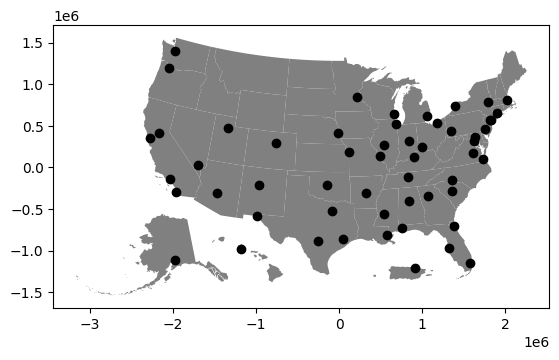

In [18]:
import geopandas as gp
from matplotlib import pyplot as plt

fbi_offices = gp.read_file("https://gist.githubusercontent.com/walkerke/a9211114fcbbe74cb04e3a6720b17d09/raw/085ca1d5dad7b37b45b0bdb5e16c160c4fb0bc37/fbi-offices.geojson")

fbi_rescaled = shift_geometry(fbi_offices)

fig, ax = plt.subplots()

us_rescaled.plot(ax = ax, color = "grey")
fbi_rescaled.plot(ax = ax, color = "black")

## Erasing water area from polygons

The Census Bureau's cartographic boundary shapefiles, available for many __pygris__ functions with the argument `cb = True`, are clipped to the US shoreline for improved cartographic display.  However, these files are still not fully satisfactory for regions with substantive water area.  For example, we can take a look at Census tracts in King County, Washington (Seattle): 

In [5]:
from pygris import tracts 

king_tracts = tracts(state = "WA", county = "King", cb = True, cache = True)

king_tracts.explore()

Using the default year of 2024
Using FIPS code '53' for input 'WA'
Using FIPS code '033' for input 'King'


Tract boundaries cross into Lake Washington, obscuring areas like Mercer Island.  

The __pygris__ function `erase_water()` is designed to automate the removal of water areas you might not want without having to go through the process of identifying water locations and carrying out GIS overlay.  `erase_water()` works by identifying counties that intersect the locations from which you'd like to erase water area, then retrieving water area shapefiles with __pygris__'s `area_water()` function and removing those areas subject to a given `area_threshold`.  A larger area threshold will only remove the largest bodies of water from your input shapes; this threshold defaults to 0.75 (the largest 25 percent of water areas). 

In [6]:
from pygris.utils import erase_water

king_tiger = tracts("WA", "King", cb = False, cache = True)

king_erased = erase_water(king_tiger)

king_erased.explore()

Using the default year of 2024
Using FIPS code '53' for input 'WA'
Using FIPS code '033' for input 'King'


In the example above, the regular TIGER/Line shapefile is used as the input to `erase_water()`; doing so limits the occurrence of _sliver polygons_, which are shapes that result from slightly-misaligned shapes in spatial overlay.  `erase_water()` does not attempt to resolve sliver polygons internally, so it is recommended that you inspect your data after using this function.  